In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch

import constant
from constant import org_cols, wsr_cols, geo_cols, semigeo_cols
import tools
import myplot
import features
from models import MLP_Regression, train_model, timeseries_kfold_validation_training
path = "SH_SC_1/"
model_path = constant.model_path + path
plot_path = constant.plot_path + path

In [2]:
%load_ext autoreload

# Load Files

In [3]:
settlement = pd.read_parquet(constant.settlement_train_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_SH_SC_path, dtype=dtype)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [4]:
len(windmill)

12

In [5]:
df = pd.merge(windmill, settlement, on="GSRN")

# Feature Extraction

In [6]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [7]:
df = features.parallelize_extract(df)

parallelize_extract time:  520.8908400535583


In [8]:
df,ply_models_rn,ws_rn = features.extract_quantiles(df, "hws_uv_rn")
df,ply_models_wsr,ws_wsr = features.extract_quantiles(df, "hws_uv_wsr")

In [9]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Parent_GSRN", "BBR_municipal", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y', 'VAERDI', 'max_VAERDI', 'In_service']

In [10]:
feat = [x for x in df.columns if x not in cols_filter]
df = tools.normalize_features(df, feat)

In [11]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])
date_s = pd.to_datetime("2019-03-01")
df_train = df[df["TIME_CET"] < date_s].sort_values(["GSRN", "TIME_CET"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s].sort_values(["TIME_CET"]).reset_index(drop=True)

In [13]:
df_train.to_parquet(constant.SH_SC_TRAIN_path, index=False)
df_evl.to_parquet(constant.SH_SC_EVL_path, index=False)

# Neural Network Train

In [3]:
df_train = pd.read_parquet(constant.SH_SC_TRAIN_path)

In [4]:
len(df_train)

104844

In [5]:
target = ["VAERDI"]
n_groups=10
lr=0.001
num_epochs=40
hidden_size = 1000
output_size = 1

## Original Features


In [6]:
model_original = MLP_Regression(
  input_size=45,
  hidden_size=hidden_size
)

### Timeserise K-Fold-Validation

In [7]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=org_cols, target=target, n_groups=n_groups, model=model_original, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.10265842825174332 test loss: 0.0958099514245987
Epoch 10 train loss: 0.051963627338409424 test loss: 0.051855914294719696
Epoch 20 train loss: 0.049942657351493835 test loss: 0.052708700299263
Epoch 30 train loss: 0.049408815801143646 test loss: 0.054165709763765335
Epoch 39 train loss: 0.04820570349693298 test loss: 0.053089432418346405
Epoch 0 train loss: 0.051335811614990234 test loss: 0.023922039195895195
Epoch 10 train loss: 0.04998867213726044 test loss: 0.023559527471661568
Epoch 20 train loss: 0.04814595729112625 test loss: 0.02382403425872326
Epoch 30 train loss: 0.046019475907087326 test loss: 0.022624704986810684
Epoch 39 train loss: 0.04386940225958824 test loss: 0.02179214544594288
Epoch 0 train loss: 0.0430673286318779 test loss: 0.026909831911325455
Epoch 10 train loss: 0.04183194786310196 test loss: 0.02810778096318245
Epoch 20 train loss: 0.04038328677415848 test loss: 0.028044339269399643
Epoch 30 train loss: 0.0387861467897892 test loss: 0.02657

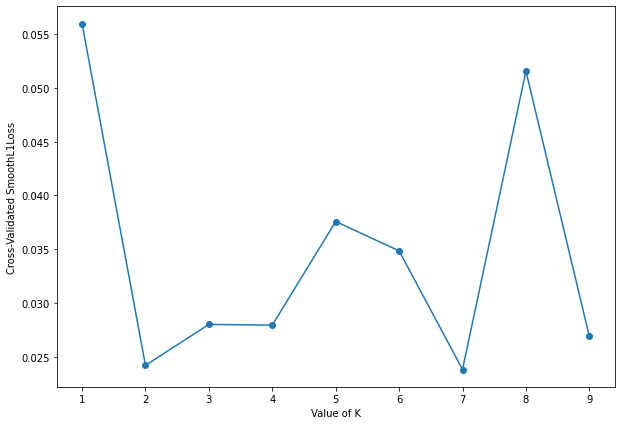

In [8]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"original_k_fold.png")

### Train model

In [18]:
x_train, y_train = df_train[org_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [19]:
model_original, train_hist_original, _ = train_model(
                                            model_original, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"original_model.pth")

Epoch 0 train loss: 0.1104336678981781
Epoch 10 train loss: 0.05353828892111778
Epoch 20 train loss: 0.050709497183561325
Epoch 30 train loss: 0.05021049454808235


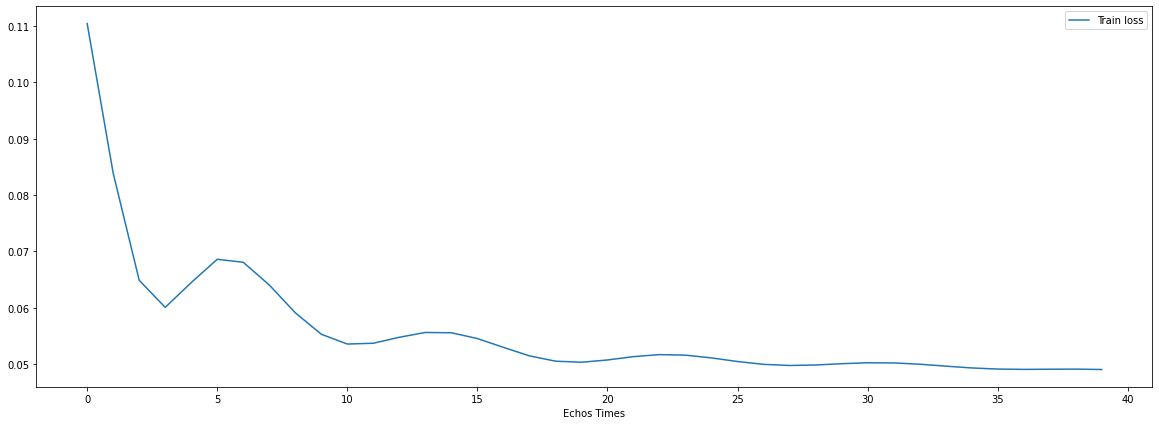

In [20]:
myplot.model_loss({"Train loss":train_hist_original}, path=plot_path+"original_loss.png")

## Windshear Features

In [9]:
model_wsr = MLP_Regression(
  input_size=47,
  hidden_size=hidden_size
)

In [10]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=wsr_cols, target=target, n_groups=n_groups, model=model_wsr, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.07663544267416 test loss: 0.07462161779403687
Epoch 10 train loss: 0.02956133708357811 test loss: 0.030000286176800728
Epoch 20 train loss: 0.026616204530000687 test loss: 0.021738721057772636
Epoch 30 train loss: 0.025370461866259575 test loss: 0.022161511704325676
Epoch 39 train loss: 0.024412455037236214 test loss: 0.02010178565979004
Epoch 0 train loss: 0.0251187551766634 test loss: 0.012830243445932865
Epoch 10 train loss: 0.025048693642020226 test loss: 0.014011089690029621
Epoch 20 train loss: 0.02426229976117611 test loss: 0.013081350363790989
Epoch 30 train loss: 0.023929109796881676 test loss: 0.012689989991486073
Epoch 39 train loss: 0.023597970604896545 test loss: 0.012822951190173626
Epoch 0 train loss: 0.023948000743985176 test loss: 0.009421171620488167
Epoch 10 train loss: 0.02424355037510395 test loss: 0.010143483057618141
Epoch 20 train loss: 0.02399478852748871 test loss: 0.010060148313641548
Epoch 30 train loss: 0.023693768307566643 test loss: 

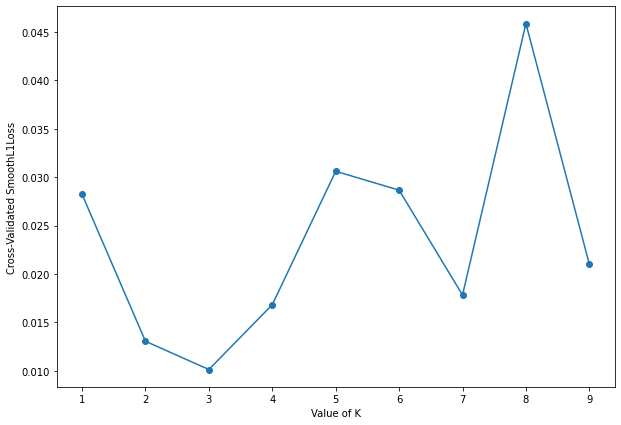

In [11]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"wsr_k_fold.png")

### Train model

In [22]:
x_train, y_train = df_train[wsr_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [23]:
model_wsr, train_hist_wsr, _ = train_model(model_wsr, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"wsr_model.pth")

Epoch 0 train loss: 0.11191863566637039
Epoch 10 train loss: 0.03436665236949921
Epoch 20 train loss: 0.026094717904925346
Epoch 30 train loss: 0.024620577692985535


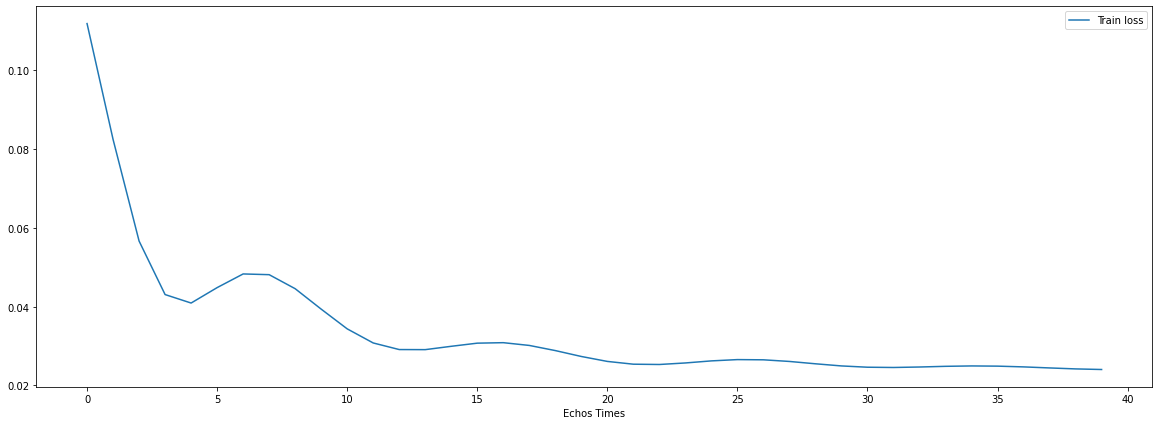

In [24]:
myplot.model_loss({"Train loss":train_hist_wsr}, path=plot_path+"wsr_loss.png")

## Geo Features

In [12]:
model_geo = MLP_Regression(
  input_size=49,
  hidden_size=hidden_size
)

In [13]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=geo_cols, target=target, n_groups=n_groups, model=model_geo, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.1048264428973198 test loss: 0.10375610738992691
Epoch 10 train loss: 0.033298615366220474 test loss: 0.03281421214342117
Epoch 20 train loss: 0.025479581207036972 test loss: 0.02570909447968006
Epoch 30 train loss: 0.024302013218402863 test loss: 0.02366364561021328
Epoch 39 train loss: 0.023516928777098656 test loss: 0.021793609485030174
Epoch 0 train loss: 0.02452881820499897 test loss: 0.013248919509351254
Epoch 10 train loss: 0.024031974375247955 test loss: 0.012574023567140102
Epoch 20 train loss: 0.023406323045492172 test loss: 0.01273508369922638
Epoch 30 train loss: 0.022930724546313286 test loss: 0.012689552269876003
Epoch 39 train loss: 0.022580940276384354 test loss: 0.012724391184747219
Epoch 0 train loss: 0.022913528606295586 test loss: 0.009310195222496986
Epoch 10 train loss: 0.023101219907402992 test loss: 0.00980492401868105
Epoch 20 train loss: 0.022515911608934402 test loss: 0.009547265246510506
Epoch 30 train loss: 0.022191550582647324 test los

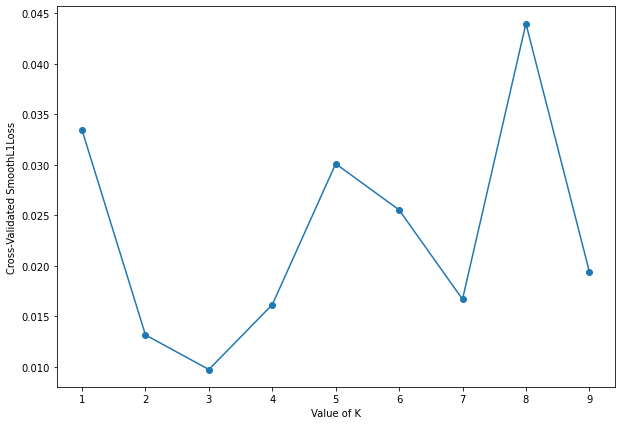

In [14]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"geo_k_fold.png")

### Train model

In [26]:
x_train, y_train = df_train[geo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [27]:
model_geo, train_hist_geo, _ = train_model(model_geo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"geo_model.pth")

Epoch 0 train loss: 0.09608432650566101
Epoch 10 train loss: 0.03077671304345131
Epoch 20 train loss: 0.02448590099811554
Epoch 30 train loss: 0.02370760217308998


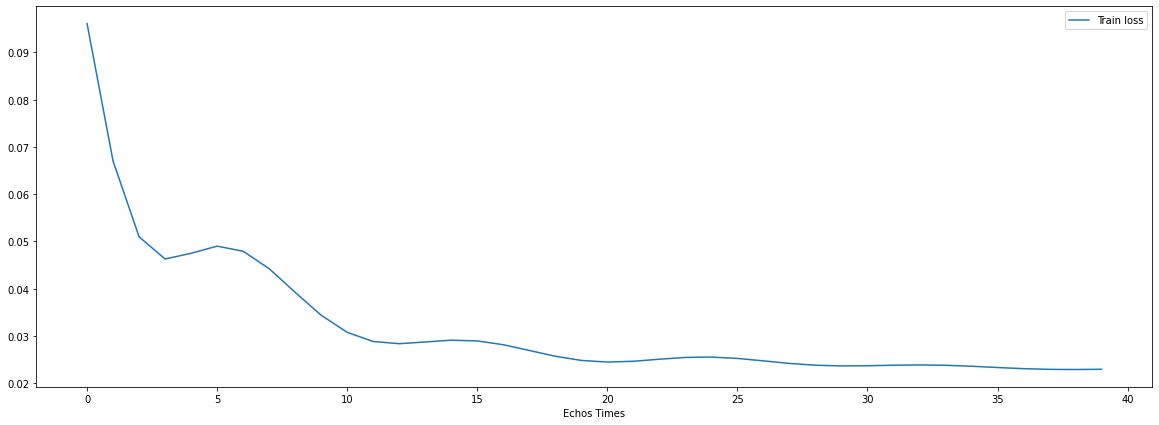

In [28]:
myplot.model_loss({"Train loss":train_hist_geo}, path=plot_path+"geo_loss.png")

## Semigeo Features

In [15]:
model_semigeo = MLP_Regression(
  input_size=50,
  hidden_size=1000
)

In [16]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=semigeo_cols, target=target, n_groups=n_groups, model=model_semigeo, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.11224984377622604 test loss: 0.10046709328889847
Epoch 10 train loss: 0.03577074408531189 test loss: 0.033357683569192886
Epoch 20 train loss: 0.025624310597777367 test loss: 0.024507952854037285
Epoch 30 train loss: 0.02381197176873684 test loss: 0.02255306951701641
Epoch 39 train loss: 0.0232743751257658 test loss: 0.021099593490362167
Epoch 0 train loss: 0.024137919768691063 test loss: 0.013589476235210896
Epoch 10 train loss: 0.023519348353147507 test loss: 0.012477266602218151
Epoch 20 train loss: 0.022968564182519913 test loss: 0.012687566690146923
Epoch 30 train loss: 0.02252936363220215 test loss: 0.012584122829139233
Epoch 39 train loss: 0.02221686951816082 test loss: 0.01271017175167799
Epoch 0 train loss: 0.022572869434952736 test loss: 0.009224826470017433
Epoch 10 train loss: 0.022481439635157585 test loss: 0.009612559340894222
Epoch 20 train loss: 0.02229766920208931 test loss: 0.009602176025509834
Epoch 30 train loss: 0.02208935283124447 test loss: 

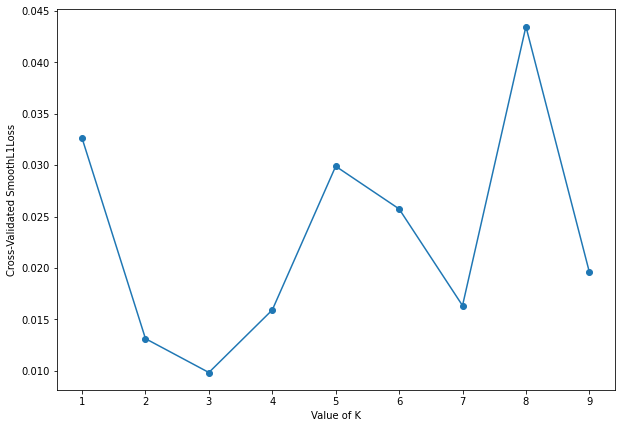

In [17]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"semigeo_k_fold.png")

### Train model

In [30]:
x_train, y_train = df_train[semigeo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [31]:
model_semigeo, train_hist_semigeo, _ = train_model(model_semigeo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"semigeo_model.pth")

Epoch 0 train loss: 0.11474135518074036
Epoch 10 train loss: 0.03958240896463394
Epoch 20 train loss: 0.026865771040320396
Epoch 30 train loss: 0.023953333497047424


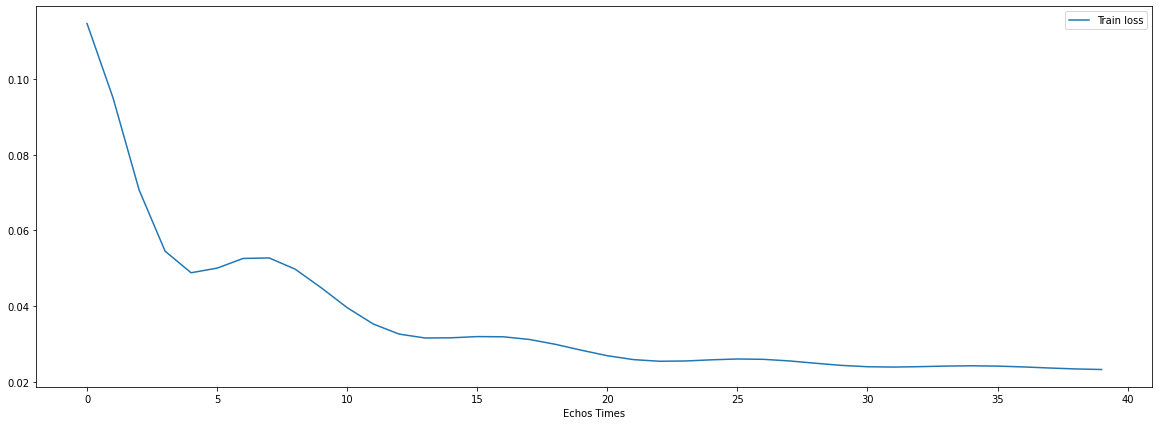

In [32]:
myplot.model_loss({"Train loss":train_hist_semigeo}, path=plot_path+"semigeo_loss.png")